In [1989]:
from preprocessing_for_adult import preprocessing_funct_not_enc, encoding_funct, K_subgroups_dataset_and_or, metrics_to_compare,encoding_funct_SMOTE
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import torch

from divexplorer import DivergenceExplorer
from divexplorer import DivergencePatternProcessor

from divexplorer.outcomes import get_false_negative_rate_outcome


In [1990]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", header = None, names = col_names)


In [1991]:
seed = 42
pd.options.display.float_format = '{:.3f}'.format


In [1992]:
epsilon = 0.01
pruning = 0.01

In [1993]:
min_sup = 0.30
percentage = 5


In [1994]:
df_train, df_val, df_test, df_holdout = preprocessing_funct_not_enc(df)
#controllo divisione dataset
print(f"TRAIN SET ROWS: ", df_train.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout.shape[0])
print(f"TEST SET ROWS: ", df_test.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [1995]:
df_train_enc, df_test_enc, df_holdout_enc, df_val_enc = encoding_funct(df_train=df_train, df_test=df_test, df_holdout=df_holdout, df_val=df_val)
#controllo coerenza con numerosità precedente
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", df_val_enc.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"HOLDOUT SET ROWS: ", df_holdout_enc.shape[0])
print(f"TEST SET ROWS: ", df_test_enc.shape[0])

TRAIN SET ROWS:  13014
VALIDATION SET ROWS:  6507
HOLDOUT SET ROWS:  6508
TEST SET ROWS:  6508


In [1996]:
#GDecisioN tree predictions
X_train = df_train_enc.drop(columns = 'income', axis = 1)
y_train = df_train_enc['income']

X_test = df_test_enc.drop(columns = 'income', axis = 1)
y_test = df_test_enc['income']

X_val = df_val_enc.drop(columns = 'income', axis = 1)
y_val = df_val_enc['income']

X_holdout = df_holdout_enc.drop(columns = 'income', axis = 1)
y_holdout = df_holdout_enc['income']

classifier_train = DecisionTreeClassifier(random_state=seed)
classifier_train.fit(X_train, y_train)
y_pred = classifier_train.predict(X_test)
cm_classifier = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_classifier, display_labels=[False, True])
#disp.plot()
#plt.show()

In [1997]:
accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before = metrics_to_compare(y_true = y_test, y_pred = y_pred )
metrics_before_df = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_test)],
})
metrics_before_df = metrics_before_df.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Test Size']

for metric in metrics_to_cast:
    metrics_before_df[metric] = metrics_before_df[metric].astype(int)

metrics_before_df

Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,6508


SUBGROUPS SEARCH

-Identifico i gruppi applicando DivExplorer sul validation not encoded (a cui ho aggiunto la feature sui falsi positivi da passare a boolean outcomes e la feature accuracy che vale 1 se la predizione è giusta e 0 se sbagliata )

-Integro nel training set dati che matchano sottogruppi problematici prendendoli dall'holdout, (primi K = 5, tutte le righe holdout che matchano)

-Ripeto training e test

In [1998]:
#predizioni per il validation set
y_pred_val_dt = classifier_train.predict(X_val)

df_val_class = X_val.copy()
df_val_class['y_val_true'] = y_val
df_val_class['y_pred'] = y_pred_val_dt

df_val_class.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,age_group,edu_num_group,hours_per_week_group,y_val_true,y_pred
18761,2,0.077,3,0,4,1,4,0,0.000,0.000,5,2,1,1,0,0
27582,3,0.048,3,1,4,0,4,1,0.000,0.000,5,5,1,2,1,0
30911,2,0.174,3,3,4,4,2,0,0.039,0.000,5,1,1,1,0,0
11128,0,0.012,2,1,2,0,2,1,0.000,0.507,5,3,4,1,1,1
683,0,0.284,3,3,2,4,2,1,0.000,0.000,5,0,1,1,0,0


In [1999]:
y_trues = df_val_class["y_val_true"]
y_preds = df_val_class["y_pred"]

df_val_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_val['fn'] = df_val_class['fn']

#aggiungo la feature accuracy a df_val non encoded che assume valore 1 se la predizione è giusta 0 se la predizione è sbagliata
#come controllo che sia corretto aggiungo la feature y_pred 
df_val['y_pred'] = df_val_class['y_pred'] 
df_val['accuracy'] = (df_val_class['y_val_true']==df_val_class['y_pred']).astype(int)
df_val.head()

,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,native-country,income,age_group,edu_num_group,hours_per_week_group,fn,y_pred,accuracy
18761,Private,0.077,Non Graduated,Divorced,Self-emp-occ,Not-in-family,White,Female,0.000,0.000,United-States,0,35-44,10 College,Overtime,NaN,0,1
27582,Self-emp,0.048,Non Graduated,Married,Self-emp-occ,Husband,White,Male,0.000,0.000,United-States,1,65-100,10 College,Part-time,1.000,0,0
30911,Private,0.174,Non Graduated,Separated,Self-emp-occ,Unmarried,Black,Female,0.039,0.000,United-States,0,25-34,10 College,Overtime,NaN,0,1
11128,Government,0.012,Master's Degree,Married,Private-occ,Husband,Black,Male,0.000,0.507,United-States,1,45-54,14 Master's Degree,Overtime,0.000,1,1
683,Government,0.284,Non Graduated,Separated,Private-occ,Unmarried,Black,Male,0.000,0.000,United-States,0,17-24,10 College,Overtime,NaN,0,1


In [2000]:
fp_diver = DivergenceExplorer(df_val)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by=["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
FP_fm.head()

,support,itemset,fn,fn_div,fn_t,length,support_count
0,0.380,"(education=Non Graduated, workclass=Private, race= White, capital-gain=0.0, capital-loss=0.0)",0.706,0.324,11.316,5,2474.000
1,0.399,"(education=Non Graduated, workclass=Private, native-country=United-States, capital-gain=0.0, capital-loss=0.0)",0.706,0.324,11.371,5,2598.000
2,0.344,"(education=Non Graduated, workclass=Private, native-country=United-States, race= White, capital-gain=0.0, capital-loss=0.0)",0.706,0.324,11.116,6,2237.000
3,0.453,"(workclass=Private, capital-loss=0.0, education=Non Graduated, capital-gain=0.0)",0.705,0.323,11.669,4,2945.000
4,0.333,"(education=Non Graduated, workclass=Private, hours_per_week_group=Overtime, capital-gain=0.0, capital-loss=0.0)",0.701,0.319,11.121,5,2168.000


In [2001]:
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()

,support,itemset,length,support_count,fn,fn_div,fn_t
3,0.453,"(workclass=Private, capital-loss=0.0, education=Non Graduated, capital-gain=0.0)",4,2945.000,0.705,0.323,11.669
5,0.311,"(marital-status=Never-married, capital-gain=0.0)",2,2021.000,0.689,0.307,5.051
7,0.608,"(capital-loss=0.0, education=Non Graduated, capital-gain=0.0)",3,3958.000,0.687,0.305,12.546
17,0.301,"(edu_num_group=9 High School Graduate, capital-gain=0.0)",2,1956.000,0.674,0.292,9.557
24,0.471,"(education=Non Graduated, workclass=Private, capital-gain=0.0)",3,3062.000,0.654,0.272,9.884


In [2002]:
# Numero totale di istanze
total_instances = len(df_pruned_fp)

# Numero di istanze con fp_div > 0 e fp_t > 2
filtered_instances = len(df_pruned_fp[(df_pruned_fp['fn_div'] > 0) & (df_pruned_fp['fn_t'] > 2)])

print('total subgroups', total_instances)
print('total problematic', filtered_instances)

total subgroups 43
total problematic 30


In [2003]:
prun_size = df_pruned_fp.shape
original_size = FP_fm.shape
print("Dim original: ", original_size)
print("Dim pruned th_redundancy ", prun_size)

Dim original:  (338, 7)
Dim pruned th_redundancy  (43, 7)


In [2004]:
K = int((percentage / 100) * filtered_instances)
K

1

BIAS MITIGATION: ADDING DATA: prendo dati dall'hold-out e li aggiungo al train set, questi dati matchano gli itemset trovati prima (i primi 5)

1. prendo dati dall'holdout con la funzione K_subgroups_dataset3 li aggiungo train 
2. riapplico encoding tutto
3. Decision tree nuovamente e vedo come sono cambiate le performance (ad es Accuracy, false positive rate, false negative rate) overall e per sottogruppi

In [2005]:
df_holdout_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_holdout, K) #da aggiungere a train set e ripetere train e test
print('prima', len(df_holdout_filtered))
df_holdout_filtered_solo1 = df_holdout_filtered[df_holdout_filtered['income']==1]



df_combinated = pd.concat([df_holdout_filtered_solo1, df_train], ignore_index=True)
df_train_mitigated= df_combinated.sample(frac=1, random_state=seed).reset_index(drop=True)

df_holdout_filtered = df_holdout_filtered_solo1 

print("dopo", len(df_holdout_filtered))

prima 2904
dopo 316


In [2006]:
#riapplico funzione di encoding, ma al posto di holdout, uso il df filtrato che devo usare per inserire dati 
df_train_enc_mit, inutile1, inutile3, inutile2 = encoding_funct(df_train=df_train_mitigated, df_test=df_test, df_holdout=df_holdout_filtered, df_val=df_val)
#controllo divisione dataset
df_train_enc_mit_fp = df_train_enc_mit  
print(f"TRAIN SET ROWS: ", df_train_enc.shape[0])
print(f"TRAIN SET MITIGATED ROWS: ", df_train_enc_mit.shape[0]) #su 32536, il 40%  dovrebbe essere circa 13014
print(f"VALIDATION SET ROWS: ", inutile1.shape[0]) #su 32536, il 20%  dovrebbe essere circa 6500
print(f"FILTERED DF holdout ROWS: ", inutile3.shape[0])
print(f"TEST SET FILTERED ROWS: ", inutile2.shape[0])

TRAIN SET ROWS:  13014
TRAIN SET MITIGATED ROWS:  13330
VALIDATION SET ROWS:  6508
FILTERED DF holdout ROWS:  316
TEST SET FILTERED ROWS:  6507


In [2007]:

X_train_mitigated = df_train_enc_mit.drop(columns = 'income', axis = 1)
y_train_mitigated = df_train_enc_mit['income']


classifier_train_mitigated = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated.fit(X_train_mitigated, y_train_mitigated)
y_mitigated_pred = classifier_train_mitigated.predict(X_test)
cm_dt = confusion_matrix(y_test, y_mitigated_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=[False, True])
#disp.plot()
#plt.show()

In [2008]:
#per veriicare cosa accade se aggiungo in modo randomico lo stesso numero di righe al train, ripeto l'analisi facebdo mitigation con righe randomiche (uguali in numero)
print(len(df_holdout_filtered))
n = len(df_holdout_filtered)
df_holdout_sampled = df_holdout_enc.sample(n=len(df_holdout_filtered), replace=True, random_state=seed)
print("verifica :", len(df_holdout_sampled)) #verifica



df_combinated_random = pd.concat([df_holdout_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random= df_combinated_random.sample(frac=1, random_state=seed).reset_index(drop=True)

X_train_mitigated_random = df_train_mitigated_random.drop(columns="income", axis = 1)
y_train_mitigated_random = df_train_mitigated_random['income']

classifier_train_mitigated_random = DecisionTreeClassifier(random_state=seed)

classifier_train_mitigated_random.fit(X_train_mitigated_random, y_train_mitigated_random)
y_mitigated_pred_random = classifier_train_mitigated_random.predict(X_test)

316
verifica : 316


In [2009]:

accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after = metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred )
accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random= metrics_to_compare(y_true = y_test, y_pred = y_mitigated_pred_random)

metrics_after_fp = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation' : [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After Mitigation(K=5, fp)': [accuracy_fp_after, f1_score_fp_after, fpr_fp_after, fnr_fp_after, fp_fp_after, fn_fp_after, len(y_train_mitigated), len(y_test)],
    'After RANDOM mitigation' : [accuracy_fp_after_random, f1_score_fp_after_random, fpr_fp_after_random, fnr_fp_after_random, fp_fp_after_random, fn_fp_after_random, len(y_train_mitigated_random), len(y_test)]
})
metrics_after_fp = metrics_after_fp.set_index('Metrics').T



metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp[metric] = metrics_after_fp[metric].astype(int)
print("Overall Gradient Boosting performance when boolean outcomes = fn ")
metrics_after_fp

Overall Gradient Boosting performance when boolean outcomes = fn 


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
"After Mitigation(K=5, fp)",0.803,0.603,0.139,0.380,686,596,13330,6508
After RANDOM mitigation,0.810,0.604,0.123,0.400,608,627,13330,6508


In [2010]:
df_test_filtered_fp = K_subgroups_dataset_and_or(df_pruned_fp, df_test, K)
inutile, df_test_filtered_enc_fp, inutile2, inutile3 = encoding_funct(df_train, df_test_filtered_fp, df_holdout, df_val)

X_test_filtered_fp = df_test_filtered_enc_fp.drop(columns='income', axis = 1)
y_true_test_filtered_fp = df_test_filtered_enc_fp['income']

y_pred_test_filtered_fp_before = classifier_train.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after = classifier_train_mitigated.predict(X_test_filtered_fp)
y_pred_test_filtered_fp_after_random = classifier_train_mitigated_random.predict(X_test_filtered_fp)

accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_before )
accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after )
accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random = metrics_to_compare(y_true = y_true_test_filtered_fp, y_pred = y_pred_test_filtered_fp_after_random)


metrics_after_fp_sottogruppi = pd.DataFrame({
    'Metrics' : ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation, on subgroups' : [accuracy_fp_sottogruppi_before, f1_score_fp_sottogruppi_before, fpr_fp_sottogruppi_before, fnr_fp_sottogruppi_before, fp_fp_sottogruppi_before, fn_fp_sottogruppi_before, len(y_train), len(y_pred_test_filtered_fp_before)],
    'After Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after, f1_score_fp_sottogruppi_after, fpr_fp_sottogruppi_after, fnr_fp_sottogruppi_after, fp_fp_sottogruppi_after, fn_fp_sottogruppi_after, len(y_train_mitigated), len(y_pred_test_filtered_fp_after)],
    'After RANDOM Mitigation(K=5, on subgroups, fp)': [accuracy_fp_sottogruppi_after_random, f1_score_fp_sottogruppi_after_random, fpr_fp_sottogruppi_after_random, fnr_fp_sottogruppi_after_random, fp_fp_sottogruppi_after_random, fn_fp_sottogruppi_after_random, len(y_train_mitigated_random), len(y_pred_test_filtered_fp_after_random)]
})
metrics_after_fp_sottogruppi = metrics_after_fp_sottogruppi.set_index('Metrics').T

metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']

for metric in metrics_to_cast:
    metrics_after_fp_sottogruppi[metric] = metrics_after_fp_sottogruppi[metric].astype(int)

metrics_after_fp


print("Subgroups Decision Tree performance when boolean outcomes = fn")
metrics_after_fp_sottogruppi

Subgroups Decision Tree performance when boolean outcomes = fn


Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
"Before Mitigation, on subgroups",0.847,0.300,0.084,0.704,222,231,13014,2957
"After Mitigation(K=5, on subgroups, fp)",0.842,0.345,0.100,0.625,262,205,13330,2957
"After RANDOM Mitigation(K=5, on subgroups, fp)",0.851,0.314,0.081,0.692,214,227,13330,2957


ANALISI DIVERGENZE

Per vedere cosa accade ai sottogruppi: vedo cosa succede alle divergenze del test dopo la mitigation

In [2011]:
#all'inizio sul test set senza nessuna mitigation
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_pred

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()



fn_div_list_no_mitigation  = df_pruned_fp["fn_div"].tolist()
#fn_div_list_no_mitigation


In [2012]:
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred 

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(by="fn_div", ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()



fn_div_list_baseline1  = df_pruned_fp["fn_div"].tolist()
#fn_div_list_baseline1


In [2013]:
#PER VEDERE COSA SUCCEDE ALLE DIVERGENZE DEI SOTTOGRUPPI CON MITIGATION RADOMICA
#prima per la baseline 1 che è quella che replica il metodo del paper 
#predizioni per il test set y_mitigated_pred 


df_test_class = X_test.copy()
df_test_class['y_test_true'] = y_test
df_test_class['y_pred'] = y_mitigated_pred_random

#df_test_class.head()

y_trues = df_test_class["y_test_true"]
y_preds = df_test_class["y_pred"]

df_test_class['fn'] =  get_false_negative_rate_outcome(y_trues, y_preds)

#aggiungo la feature 'fn' a df_val non encoded
df_test['fn'] = df_test_class['fn']

#come controllo che sia corretto aggiungo la feature y_pred 
df_test['y_pred'] = df_test_class['y_pred'] 

#df_test.head()

#sottogruppi

fp_diver = DivergenceExplorer(df_test)
attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'age_group', 'edu_num_group', 'hours_per_week_group']
FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fn'])
FP_fm = FP_fm.sort_values(["fn_div", "fn_t"], ascending=False, ignore_index=True)
pd.set_option('display.max_colwidth', None)
#FP_fm.head()
#pruning 
fp_details = DivergencePatternProcessor(FP_fm, 'fn')
df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=epsilon)
df_pruned_fp = df_pruned_fp.sort_values("fn_div", ascending=False)
df_pruned_fp.head()



fn_div_list_random_per_confrontare_con_baseline1  = df_pruned_fp["fn_div"].tolist()
#fn_div_list_random_per_confrontare_con_baseline1


In [2014]:
# Calcolo delle medie e del massimo con valore assoluto solo dopo
media_fn_div_list_no_mitigation = np.nanmean(fn_div_list_no_mitigation)
media_fn_div_list_nomitigation_primi10 = np.nanmean(fn_div_list_no_mitigation[:10])
media_fn_div_list_nomitigation_primi20 = np.nanmean(fn_div_list_no_mitigation[:20])
media_fn_div_list_nomitigation_primi40 = np.nanmean(fn_div_list_no_mitigation[:40])
massimo_valore_assoluto_fn_div_no_mitigation = max(abs(x) for x in fn_div_list_no_mitigation)

media_fn_div_list_baseline1 = np.nanmean(fn_div_list_baseline1)
media_fn_div_list_baseline1_primi10 = np.nanmean(fn_div_list_baseline1[:10])
media_fn_div_list_baseline1_primi20 = np.nanmean(fn_div_list_baseline1[:20])
media_fn_div_list_baseline1_primi40 = np.nanmean(fn_div_list_baseline1[:40])
fn_div_massimo_valore_assoluto_fn_div_baseline1 = max(abs(x) for x in fn_div_list_baseline1)

media_fn_div_list_random_per_confrontare_con_baseline1 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1)
media_fn_div_list_random_per_confrontare_con_baseline1_primi10 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1[:10])
media_fn_div_list_random_per_confrontare_con_baseline1_primi20 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1[:20])
media_fn_div_list_random_per_confrontare_con_baseline1_primi40 = np.nanmean(fn_div_list_random_per_confrontare_con_baseline1[:40])
massimo_valore_assoluto_fn_div_random_per_confrontare_con_baseline1 = max(abs(x) for x in fn_div_list_random_per_confrontare_con_baseline1)

# Creazione del DataFrame finale
divergence_after_fn_sottogruppi = pd.DataFrame({
    'Metrics': [
        'Accuracy', 'F1 Score', 'media divergenze', 'max div', 'media div primi 10', 'media div primi 20', 'media div primi 40', '# new samples'
    ],
    'Before Mitigation': [
        accuracy_before, f1_score_before, media_fn_div_list_no_mitigation, massimo_valore_assoluto_fn_div_no_mitigation,
        media_fn_div_list_nomitigation_primi10, media_fn_div_list_nomitigation_primi20, media_fn_div_list_nomitigation_primi40, 0
    ],
    'After Mitigation(K=5 fp)': [
        accuracy_fp_after, f1_score_fp_after, media_fn_div_list_baseline1, fn_div_massimo_valore_assoluto_fn_div_baseline1,
        media_fn_div_list_baseline1_primi10, media_fn_div_list_baseline1_primi20, media_fn_div_list_baseline1_primi40, len(df_holdout_filtered)
    ],
    'After RANDOM Mitigation(K=5 fp)': [
        accuracy_fp_after_random, f1_score_fp_after_random, media_fn_div_list_random_per_confrontare_con_baseline1,
        massimo_valore_assoluto_fn_div_random_per_confrontare_con_baseline1, media_fn_div_list_random_per_confrontare_con_baseline1_primi10,
        media_fn_div_list_random_per_confrontare_con_baseline1_primi20, media_fn_div_list_random_per_confrontare_con_baseline1_primi40,
        len(df_holdout_filtered)
    ]
})

# Trasposizione per visualizzazione
divergence_after_fn_sottogruppi = divergence_after_fn_sottogruppi.set_index('Metrics').T

divergence_after_fn_sottogruppi




Metrics,Accuracy,F1 Score,media divergenze,max div,media div primi 10,media div primi 20,media div primi 40,# new samples
Before Mitigation,0.803,0.593,0.097,0.429,0.260,0.203,0.137,0.000
After Mitigation(K=5 fp),0.803,0.603,0.081,0.410,0.250,0.216,0.164,316.000
After RANDOM Mitigation(K=5 fp),0.810,0.604,0.093,0.473,0.292,0.228,0.147,316.000


QUI INIZIA SMOTE come si deve DA METTERE NEL REPORT
BIAS MITIGATION SMOTENC

- FISSO N VARIA p, p è la probabilità che il campione simulato sia di classe 0 qui (perchè voglio diminuire il numero di falsi negativi)
- FISSO p VARIA N , aumento il numero di 0 per diminuire il numero di falsi negativi  

In [2015]:
from imblearn.over_sampling import SMOTENC
df_val_filtered = K_subgroups_dataset_and_or(df_pruned_fp, df_val, K)
print("Righe del dataset filtrato qunado K = 5",len(df_val_filtered))
#df_val_filtered.head() #var categoriche e numeriche 
#print(len(df_val_filtered)) #--2610 con = 5
df_val_filtered, inutile12, inutile222 = encoding_funct_SMOTE(df_val_filtered, df_test, df_holdout)
X_to_SMOTE =  df_val_filtered.drop(columns = ['fn', 'y_pred', 'accuracy', 'income'], axis = 1)
y_to_SMOTE = df_val_filtered['income']
X_to_SMOTE.head()

categorical_features = [0, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]

Righe del dataset filtrato qunado K = 5 1947


In [2016]:
count_1 = df_val_filtered['income'].sum()
count_0 = len(df_val_filtered) - count_1
count_1, count_0

(52, 1895)

QUI MODIFICO FACENDO SMOTE SU DF_VAL_FILTERED 

In [2017]:
'''smote_nc = SMOTENC(categorical_features=categorical_features,random_state=seed)
X_to_SMOTE, y_to_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
count_1 = y_to_SMOTE.sum()
count_0 = len(y_to_SMOTE)-count_1
count_0, count_1'''

'smote_nc = SMOTENC(categorical_features=categorical_features,random_state=seed)\nX_to_SMOTE, y_to_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)\ncount_1 = y_to_SMOTE.sum()\ncount_0 = len(y_to_SMOTE)-count_1\ncount_0, count_1'

per confronto con targeted
N come len_df_holdout_filtered

In [2018]:
K

1

In [2019]:
p_values = np.arange(0.5, 1.05, 0.05)
p_values = np.round(p_values, 2).tolist()
p_values

[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]

In [2020]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier

# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}

N = len(df_holdout_filtered)
original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 316,0.810,0.604,0.123,0.400,608,627,13330,6508
After SMOTE N = 316 p_class 1 = 0.5,0.803,0.594,0.131,0.402,649,631,13330,6508
After SMOTE N = 316 p_class 1 = 0.55,0.803,0.595,0.133,0.399,659,625,13330,6508
After SMOTE N = 316 p_class 1 = 0.6,0.802,0.592,0.133,0.404,655,634,13330,6508
After SMOTE N = 316 p_class 1 = 0.65,0.803,0.595,0.131,0.402,649,630,13330,6508
After SMOTE N = 316 p_class 1 = 0.7,0.803,0.594,0.132,0.402,653,630,13330,6508
After SMOTE N = 316 p_class 1 = 0.75,0.801,0.591,0.134,0.402,664,631,13330,6508
After SMOTE N = 316 p_class 1 = 0.8,0.802,0.592,0.132,0.406,651,636,13330,6508
After SMOTE N = 316 p_class 1 = 0.85,0.802,0.592,0.133,0.404,655,633,13330,6508


In [2021]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_confronto = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_confronto



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 316,0.810,0.604,608,627,1235,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 316 p_class 1 = 0.5,0.803,0.594,649,631,1280,0.095,0.303,0.245,0.195,0.128
After SMOTE N = 316 p_class 1 = 0.55,0.803,0.595,659,625,1284,0.110,0.359,0.259,0.211,0.149
After SMOTE N = 316 p_class 1 = 0.6,0.802,0.592,655,634,1289,0.091,0.354,0.249,0.194,0.121
After SMOTE N = 316 p_class 1 = 0.65,0.803,0.595,649,630,1279,0.095,0.324,0.241,0.196,0.144
After SMOTE N = 316 p_class 1 = 0.7,0.803,0.594,653,630,1283,0.090,0.389,0.254,0.202,0.140
After SMOTE N = 316 p_class 1 = 0.75,0.801,0.591,664,631,1295,0.091,0.340,0.239,0.183,0.115
After SMOTE N = 316 p_class 1 = 0.8,0.802,0.592,651,636,1287,0.109,0.352,0.260,0.216,0.157
After SMOTE N = 316 p_class 1 = 0.85,0.802,0.592,655,633,1288,0.106,0.387,0.251,0.204,0.140


N = 1000

In [2022]:
N = 1000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 1000,0.806,0.603,0.132,0.389,652,610,14014,6508
After SMOTE N = 1000 p_class 1 = 0.5,0.804,0.592,0.129,0.409,636,641,14014,6508
After SMOTE N = 1000 p_class 1 = 0.55,0.804,0.598,0.133,0.395,659,619,14014,6508
After SMOTE N = 1000 p_class 1 = 0.6,0.802,0.592,0.133,0.403,659,632,14014,6508
After SMOTE N = 1000 p_class 1 = 0.65,0.801,0.588,0.132,0.411,652,644,14014,6508
After SMOTE N = 1000 p_class 1 = 0.7,0.802,0.589,0.130,0.411,644,644,14014,6508
After SMOTE N = 1000 p_class 1 = 0.75,0.800,0.583,0.131,0.418,647,656,14014,6508
After SMOTE N = 1000 p_class 1 = 0.8,0.806,0.599,0.130,0.398,641,624,14014,6508
After SMOTE N = 1000 p_class 1 = 0.85,0.804,0.597,0.131,0.399,648,625,14014,6508


In [2023]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_1K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_1K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 1000,0.806,0.603,652,610,1262,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 1000 p_class 1 = 0.5,0.804,0.592,636,641,1277,0.097,0.414,0.277,0.229,0.178
After SMOTE N = 1000 p_class 1 = 0.55,0.804,0.598,659,619,1278,0.095,0.331,0.262,0.203,0.142
After SMOTE N = 1000 p_class 1 = 0.6,0.802,0.592,659,632,1291,0.089,0.355,0.238,0.190,0.139
After SMOTE N = 1000 p_class 1 = 0.65,0.801,0.588,652,644,1296,0.103,0.396,0.273,0.219,0.152
After SMOTE N = 1000 p_class 1 = 0.7,0.802,0.589,644,644,1288,0.100,0.412,0.276,0.217,0.154
After SMOTE N = 1000 p_class 1 = 0.75,0.800,0.583,647,656,1303,0.103,0.372,0.280,0.231,0.160
After SMOTE N = 1000 p_class 1 = 0.8,0.806,0.599,641,624,1265,0.107,0.360,0.263,0.213,0.149
After SMOTE N = 1000 p_class 1 = 0.85,0.804,0.597,648,625,1273,0.105,0.359,0.245,0.186,0.109


N = 2000

In [2024]:
N = 2000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 2000,0.804,0.600,0.134,0.390,664,611,15014,6508
After SMOTE N = 2000 p_class 1 = 0.5,0.805,0.598,0.130,0.399,641,626,15014,6508
After SMOTE N = 2000 p_class 1 = 0.55,0.806,0.599,0.129,0.399,637,626,15014,6508
After SMOTE N = 2000 p_class 1 = 0.6,0.803,0.591,0.131,0.408,645,640,15014,6508
After SMOTE N = 2000 p_class 1 = 0.65,0.804,0.595,0.131,0.401,649,629,15014,6508
After SMOTE N = 2000 p_class 1 = 0.7,0.804,0.595,0.130,0.404,641,633,15014,6508
After SMOTE N = 2000 p_class 1 = 0.75,0.801,0.587,0.132,0.412,651,646,15014,6508
After SMOTE N = 2000 p_class 1 = 0.8,0.801,0.589,0.132,0.409,651,642,15014,6508
After SMOTE N = 2000 p_class 1 = 0.85,0.803,0.591,0.129,0.410,639,643,15014,6508


In [2025]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)



metrics_after_fp_SMOTE_2K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_2K


Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 2000,0.804,0.600,664,611,1275,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 2000 p_class 1 = 0.5,0.805,0.598,641,626,1267,0.116,0.327,0.259,0.201,0.123
After SMOTE N = 2000 p_class 1 = 0.55,0.806,0.599,637,626,1263,0.128,0.375,0.257,0.202,0.128
After SMOTE N = 2000 p_class 1 = 0.6,0.803,0.591,645,640,1285,0.100,0.334,0.253,0.204,0.142
After SMOTE N = 2000 p_class 1 = 0.65,0.804,0.595,649,629,1278,0.112,0.341,0.290,0.249,0.193
After SMOTE N = 2000 p_class 1 = 0.7,0.804,0.595,641,633,1274,0.114,0.320,0.274,0.227,0.154
After SMOTE N = 2000 p_class 1 = 0.75,0.801,0.587,651,646,1297,0.100,0.362,0.245,0.197,0.123
After SMOTE N = 2000 p_class 1 = 0.8,0.801,0.589,651,642,1293,0.092,0.349,0.259,0.214,0.149
After SMOTE N = 2000 p_class 1 = 0.85,0.803,0.591,639,643,1282,0.097,0.364,0.259,0.212,0.149


N = 3000

In [2026]:
N = 3000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 3000,0.809,0.604,0.126,0.395,622,620,16014,6508
After SMOTE N = 3000 p_class 1 = 0.5,0.804,0.595,0.130,0.404,641,633,16014,6508
After SMOTE N = 3000 p_class 1 = 0.55,0.802,0.589,0.131,0.409,648,642,16014,6508
After SMOTE N = 3000 p_class 1 = 0.6,0.802,0.589,0.130,0.411,642,645,16014,6508
After SMOTE N = 3000 p_class 1 = 0.65,0.801,0.589,0.132,0.409,650,642,16014,6508
After SMOTE N = 3000 p_class 1 = 0.7,0.803,0.594,0.131,0.402,648,631,16014,6508
After SMOTE N = 3000 p_class 1 = 0.75,0.799,0.583,0.133,0.416,658,652,16014,6508
After SMOTE N = 3000 p_class 1 = 0.8,0.803,0.593,0.132,0.404,651,633,16014,6508
After SMOTE N = 3000 p_class 1 = 0.85,0.800,0.586,0.132,0.413,652,647,16014,6508


In [2027]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)


metrics_after_fp_SMOTE_3K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_3K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 3000,0.809,0.604,622,620,1242,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 3000 p_class 1 = 0.5,0.804,0.595,641,633,1274,0.101,0.370,0.236,0.190,0.131
After SMOTE N = 3000 p_class 1 = 0.55,0.802,0.589,648,642,1290,0.103,0.332,0.256,0.202,0.143
After SMOTE N = 3000 p_class 1 = 0.6,0.802,0.589,642,645,1287,0.099,0.331,0.264,0.208,0.150
After SMOTE N = 3000 p_class 1 = 0.65,0.801,0.589,650,642,1292,0.127,0.397,0.299,0.254,0.193
After SMOTE N = 3000 p_class 1 = 0.7,0.803,0.594,648,631,1279,0.108,0.340,0.268,0.223,0.166
After SMOTE N = 3000 p_class 1 = 0.75,0.799,0.583,658,652,1310,0.099,0.358,0.267,0.218,0.153
After SMOTE N = 3000 p_class 1 = 0.8,0.803,0.593,651,633,1284,0.129,0.396,0.303,0.255,0.180
After SMOTE N = 3000 p_class 1 = 0.85,0.800,0.586,652,647,1299,0.121,0.424,0.307,0.242,0.148


N = 4000

In [2028]:
N = 4000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 4000,0.809,0.607,0.128,0.388,634,609,17014,6508
After SMOTE N = 4000 p_class 1 = 0.5,0.807,0.599,0.127,0.402,628,630,17014,6508
After SMOTE N = 4000 p_class 1 = 0.55,0.804,0.594,0.130,0.404,641,634,17014,6508
After SMOTE N = 4000 p_class 1 = 0.6,0.802,0.589,0.131,0.409,649,642,17014,6508
After SMOTE N = 4000 p_class 1 = 0.65,0.801,0.585,0.131,0.416,646,652,17014,6508
After SMOTE N = 4000 p_class 1 = 0.7,0.804,0.595,0.130,0.404,641,633,17014,6508
After SMOTE N = 4000 p_class 1 = 0.75,0.804,0.594,0.130,0.404,642,634,17014,6508
After SMOTE N = 4000 p_class 1 = 0.8,0.802,0.592,0.133,0.404,657,633,17014,6508
After SMOTE N = 4000 p_class 1 = 0.85,0.807,0.600,0.128,0.399,634,625,17014,6508


In [2029]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_4K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_4K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 4000,0.809,0.607,634,609,1243,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 4000 p_class 1 = 0.5,0.807,0.599,628,630,1258,0.098,0.356,0.263,0.206,0.146
After SMOTE N = 4000 p_class 1 = 0.55,0.804,0.594,641,634,1275,0.111,0.354,0.287,0.235,0.172
After SMOTE N = 4000 p_class 1 = 0.6,0.802,0.589,649,642,1291,0.100,0.349,0.264,0.221,0.166
After SMOTE N = 4000 p_class 1 = 0.65,0.801,0.585,646,652,1298,0.081,0.358,0.251,0.198,0.135
After SMOTE N = 4000 p_class 1 = 0.7,0.804,0.595,641,633,1274,0.137,0.396,0.298,0.243,0.164
After SMOTE N = 4000 p_class 1 = 0.75,0.804,0.594,642,634,1276,0.107,0.359,0.295,0.251,0.186
After SMOTE N = 4000 p_class 1 = 0.8,0.802,0.592,657,633,1290,0.115,0.396,0.301,0.253,0.193
After SMOTE N = 4000 p_class 1 = 0.85,0.807,0.600,634,625,1259,0.114,0.401,0.295,0.253,0.179


N = 5000

In [2030]:
N = 5000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 5000,0.803,0.593,0.132,0.402,654,631,18014,6508
After SMOTE N = 5000 p_class 1 = 0.5,0.803,0.595,0.133,0.399,657,625,18014,6508
After SMOTE N = 5000 p_class 1 = 0.55,0.802,0.594,0.133,0.401,657,629,18014,6508
After SMOTE N = 5000 p_class 1 = 0.6,0.807,0.600,0.129,0.398,635,624,18014,6508
After SMOTE N = 5000 p_class 1 = 0.65,0.805,0.595,0.127,0.408,627,639,18014,6508
After SMOTE N = 5000 p_class 1 = 0.7,0.805,0.593,0.127,0.409,629,641,18014,6508
After SMOTE N = 5000 p_class 1 = 0.75,0.806,0.598,0.127,0.402,629,631,18014,6508
After SMOTE N = 5000 p_class 1 = 0.8,0.807,0.600,0.127,0.400,629,627,18014,6508
After SMOTE N = 5000 p_class 1 = 0.85,0.807,0.592,0.122,0.418,604,655,18014,6508


In [2031]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_5K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_5K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 5000,0.803,0.593,654,631,1285,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 5000 p_class 1 = 0.5,0.803,0.595,657,625,1282,0.103,0.376,0.271,0.212,0.153
After SMOTE N = 5000 p_class 1 = 0.55,0.802,0.594,657,629,1286,0.129,0.373,0.290,0.254,0.190
After SMOTE N = 5000 p_class 1 = 0.6,0.807,0.600,635,624,1259,0.121,0.384,0.296,0.242,0.174
After SMOTE N = 5000 p_class 1 = 0.65,0.805,0.595,627,639,1266,0.120,0.334,0.290,0.242,0.170
After SMOTE N = 5000 p_class 1 = 0.7,0.805,0.593,629,641,1270,0.108,0.446,0.306,0.250,0.183
After SMOTE N = 5000 p_class 1 = 0.75,0.806,0.598,629,631,1260,0.135,0.379,0.305,0.260,0.191
After SMOTE N = 5000 p_class 1 = 0.8,0.807,0.600,629,627,1256,0.111,0.400,0.318,0.279,0.218
After SMOTE N = 5000 p_class 1 = 0.85,0.807,0.592,604,655,1259,0.111,0.419,0.297,0.241,0.178


N = 6000

In [2032]:
N = 6000
# Dizionari per salvare i risultati
X_train_mit_SMOTE_dict = {}
y_train_mit_SMOTE_dict = {}
y_pred_SMOTE_dict = {}
metrics_results_compare = {}
fp_div_results = {}


original_size = len(X_to_SMOTE)

for p in p_values:
    sampling_strategy = {1: count_1 + int(N * p), 0: count_0 + int(N * (1 - p))}
    
    smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=categorical_features, random_state=seed)
    X_sampled_SMOTE, y_sampled_SMOTE = smote_nc.fit_resample(X_to_SMOTE, y_to_SMOTE)
    
    X_generated = X_sampled_SMOTE[-N:]
    y_generated = y_sampled_SMOTE[-N:]
    
    X_train_mit_SMOTE_dict[p] = pd.concat([X_train, X_generated], ignore_index=True)
    y_train_mit_SMOTE_dict[p] = pd.concat([y_train, y_generated], ignore_index=True)
    
    classifier = DecisionTreeClassifier(random_state=seed)
    classifier.fit(X_train_mit_SMOTE_dict[p], y_train_mit_SMOTE_dict[p])
    y_pred_SMOTE_dict[p] = classifier.predict(X_test)
    
    metrics_results_compare[p] = metrics_to_compare(y_true=y_test, y_pred=y_pred_SMOTE_dict[p])
    
    df_test_class = X_test.copy()
    df_test_class['y_test_true'] = y_test
    df_test_class['y_pred'] = y_pred_SMOTE_dict[p]
    df_test_class['fp'] = get_false_negative_rate_outcome(df_test_class["y_test_true"], df_test_class["y_pred"])
    
    df_test['fp'] = df_test_class['fp']
    df_test['y_pred'] = df_test_class['y_pred']
    
    fp_diver = DivergenceExplorer(df_test)
    attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                  'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                  'age_group', 'edu_num_group', 'hours_per_week_group']
    
    FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
    FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)
    
    fp_details = DivergencePatternProcessor(FP_fm, 'fp')
    df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
    df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)
    
    fp_div_results[p] = df_pruned_fp["fp_div"].tolist()

# Valori randomici per confronto senza mitigazione
df_holdout_smote_sampled = df_holdout_enc.sample(n=N, replace=True, random_state=seed)
df_combinated_random_smote = pd.concat([df_holdout_smote_sampled, df_train_enc], ignore_index=True)
df_train_mitigated_random_smote = df_combinated_random_smote.sample(frac=1, random_state=seed).reset_index(drop=True)
X_train_mitigated_random_smote = df_train_mitigated_random_smote.drop(columns="income", axis=1)
y_train_mitigated_random_smote = df_train_mitigated_random_smote['income']

classifier_train_mitigated_random_smote_p = DecisionTreeClassifier(random_state=seed)
classifier_train_mitigated_random_smote_p.fit(X_train_mitigated_random_smote, y_train_mitigated_random_smote)
y_mitigated_pred_random_smote_p = classifier_train_mitigated_random_smote_p.predict(X_test)

accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p = metrics_to_compare(y_true=y_test, y_pred=y_mitigated_pred_random_smote_p)

metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'False Positives', 'False Negatives', 'Train Size', 'Test Size'],
    'Before Mitigation': [accuracy_before, f1_score_before, fpr_before, fnr_before, fp_before, fn_before, len(y_train), len(y_test)],
    'After RANDOM mitigation N = {}'.format(N): [accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, fpr_fp_after_SMOTE_random_p, fnr_fp_after_SMOTE_random_p, fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, len(X_train_mitigated_random_smote), len(y_mitigated_pred_random_smote_p)]
})

for p in p_values:
    metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = list(metrics_results_compare[p]) + [len(X_train_mit_SMOTE_dict[p]), len(y_pred_SMOTE_dict[p])]

metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T
metrics_to_cast = ['False Positives', 'False Negatives', 'Train Size', 'Test Size']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

# Mostrare la tabella finale
metrics_after_fp_SMOTE



Metrics,Accuracy,F1 Score,False Positive Rate,False Negative Rate,False Positives,False Negatives,Train Size,Test Size
Before Mitigation,0.803,0.593,0.130,0.407,641,638,13014,6508
After RANDOM mitigation N = 6000,0.807,0.605,0.132,0.386,651,606,19014,6508
After SMOTE N = 6000 p_class 1 = 0.5,0.801,0.591,0.135,0.402,666,630,19014,6508
After SMOTE N = 6000 p_class 1 = 0.55,0.806,0.595,0.127,0.408,625,639,19014,6508
After SMOTE N = 6000 p_class 1 = 0.6,0.807,0.598,0.126,0.404,620,634,19014,6508
After SMOTE N = 6000 p_class 1 = 0.65,0.808,0.601,0.127,0.399,627,625,19014,6508
After SMOTE N = 6000 p_class 1 = 0.7,0.807,0.596,0.124,0.409,614,642,19014,6508
After SMOTE N = 6000 p_class 1 = 0.75,0.807,0.593,0.123,0.415,608,651,19014,6508
After SMOTE N = 6000 p_class 1 = 0.8,0.805,0.593,0.125,0.413,619,647,19014,6508
After SMOTE N = 6000 p_class 1 = 0.85,0.811,0.605,0.123,0.398,607,624,19014,6508


In [2033]:
# Dizionario per salvare i risultati della divergenza
fp_div_results = {}

# Lista degli esperimenti con l'ordine desiderato
experiments = {
    "no_mitigation": y_pred,  # Prima Before Mitigation
    "random": y_mitigated_pred_random,  # Poi Random
    "SMOTE": p_values  # Infine SMOTE per tutti i valori di p
}

# Iteriamo su ogni esperimento nell'ordine corretto
for exp_name, preds in experiments.items():
    # Se è "SMOTE", iteriamo su p_values, altrimenti è un unico array di predizioni
    if exp_name == "SMOTE":
        iter_values = preds  # Lista dei valori di p
    else:
        iter_values = [None]  # Solo una iterazione, con chiave fissa per il dizionario

    for p in iter_values:
        # Creazione del DataFrame per il test set
        df_test_class = X_test.copy()
        df_test_class['y_test_true'] = y_test
        
        # Se l'esperimento è SMOTE, usiamo il dizionario dei risultati, altrimenti prendiamo direttamente il valore
        df_test_class['y_pred'] = y_pred_SMOTE_dict[p] if exp_name == "SMOTE" else preds

        # Calcolo falsi positivi
        y_trues = df_test_class["y_test_true"]
        y_preds = df_test_class["y_pred"]
        df_test_class['fp'] = get_false_negative_rate_outcome(y_trues, y_preds)

        # Aggiunta delle feature calcolate a df_test
        df_test['fp'] = df_test_class['fp']
        df_test['y_pred'] = df_test_class['y_pred']

        # Analisi della divergenza
        fp_diver = DivergenceExplorer(df_test)
        attributes = ['workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 'relationship',
                      'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 
                      'age_group', 'edu_num_group', 'hours_per_week_group']
        
        FP_fm = fp_diver.get_pattern_divergence(min_support=min_sup, attributes=attributes, boolean_outcomes=['fp'])
        FP_fm = FP_fm.sort_values(by="fp_div", ascending=False, ignore_index=True)

        # Pruning
        fp_details = DivergencePatternProcessor(FP_fm, 'fp')
        df_pruned_fp = fp_details.redundancy_pruning(th_redundancy=0.01)
        df_pruned_fp = df_pruned_fp.sort_values("fp_div", ascending=False)

        # Salviamo i risultati in un dizionario con una chiave fissa per no_mitigation/random
        key = (exp_name, p) if exp_name == "SMOTE" else exp_name
        fp_div_results[key] = df_pruned_fp["fp_div"].tolist()

# Calcolo delle metriche dai risultati della divergenza
results = {
    key: {
        "media": np.nanmean(fp_div_list),
        "media_primi10": np.nanmean(fp_div_list[:10]),
        "media_primi20": np.nanmean(fp_div_list[:20]),
        "media_primi40": np.nanmean(fp_div_list[:40]),
        "massimo_valore_assoluto": np.nanmax(np.abs(fp_div_list))
    }
    for key, fp_div_list in fp_div_results.items()
}


# Creazione della tabella dei risultati con le nuove metriche
metrics_after_fp_SMOTE = pd.DataFrame({
    'Metrics': ['Accuracy', 'F1 Score', 'False Positives', 'False Negatives', 'Total Errors', 
                'Mean Divergence', 'Max Divergence', 'Top 10 Div', 'Top 20 Div', 'Top 40 Div'],
    'Before Mitigation': [
        accuracy_before, f1_score_before, fp_before, fn_before, 
        fp_before + fn_before, results['no_mitigation']['media'], results['no_mitigation']['massimo_valore_assoluto'], 
        results['no_mitigation']['media_primi10'], results['no_mitigation']['media_primi20'], results['no_mitigation']['media_primi40']
    ],
    'After RANDOM mitigation N = {}'.format(N): [
        accuracy_fp_after_SMOTE_random_p, f1_score_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p, fn_fp_after_SMOTE_random_p, 
        fp_fp_after_SMOTE_random_p + fn_fp_after_SMOTE_random_p,
        results['random']['media'], results['random']['massimo_valore_assoluto'],
        results['random']['media_primi10'], results['random']['media_primi20'], results['random']['media_primi40']
    ]
})

# Aggiunta delle colonne per ogni valore di p
for p in p_values:
    if ('SMOTE', p) in results:
        metrics_after_fp_SMOTE[f'After SMOTE N = {N} p_class 1 = {p}'] = [
            metrics_results_compare[p][0],  # Accuracy
            metrics_results_compare[p][1],  # F1 Score
            metrics_results_compare[p][4],  # False Positives
            metrics_results_compare[p][5],  # False Negatives
            metrics_results_compare[p][4] + metrics_results_compare[p][5],  # Total Errors
            results[('SMOTE', p)]['media'],
            results[('SMOTE', p)]['massimo_valore_assoluto'],
            results[('SMOTE', p)]['media_primi10'],
            results[('SMOTE', p)]['media_primi20'],
            results[('SMOTE', p)]['media_primi40']
        ]

# Trasformare la tabella in formato leggibile
metrics_after_fp_SMOTE = metrics_after_fp_SMOTE.set_index('Metrics').T

# Castare i valori interi per alcune metriche
metrics_to_cast = ['False Positives', 'False Negatives', 'Total Errors']
for metric in metrics_to_cast:
    metrics_after_fp_SMOTE[metric] = metrics_after_fp_SMOTE[metric].astype(int)

metrics_after_fp_SMOTE_6K = metrics_after_fp_SMOTE
metrics_after_fp_SMOTE_6K



Metrics,Accuracy,F1 Score,False Positives,False Negatives,Total Errors,Mean Divergence,Max Divergence,Top 10 Div,Top 20 Div,Top 40 Div
Before Mitigation,0.803,0.593,641,638,1279,0.097,0.429,0.260,0.203,0.137
After RANDOM mitigation N = 6000,0.807,0.605,651,606,1257,0.093,0.473,0.292,0.228,0.147
After SMOTE N = 6000 p_class 1 = 0.5,0.801,0.591,666,630,1296,0.119,0.372,0.295,0.242,0.159
After SMOTE N = 6000 p_class 1 = 0.55,0.806,0.595,625,639,1264,0.123,0.374,0.295,0.248,0.180
After SMOTE N = 6000 p_class 1 = 0.6,0.807,0.598,620,634,1254,0.119,0.354,0.276,0.220,0.137
After SMOTE N = 6000 p_class 1 = 0.65,0.808,0.601,627,625,1252,0.107,0.392,0.276,0.229,0.172
After SMOTE N = 6000 p_class 1 = 0.7,0.807,0.596,614,642,1256,0.117,0.409,0.303,0.249,0.185
After SMOTE N = 6000 p_class 1 = 0.75,0.807,0.593,608,651,1259,0.121,0.403,0.301,0.259,0.197
After SMOTE N = 6000 p_class 1 = 0.8,0.805,0.593,619,647,1266,0.116,0.345,0.285,0.245,0.186
After SMOTE N = 6000 p_class 1 = 0.85,0.811,0.605,607,624,1231,0.102,0.384,0.304,0.259,0.195


In [2034]:
import json
import os

# Nome del file JSON
json_filename = "false_negatives_K.json"

# Controlla se il file esiste già per evitare di sovrascrivere
if os.path.exists(json_filename):
    with open(json_filename, "r") as f:
        false_negatives_data = json.load(f)
else:
    false_negatives_data = {}

# Lista dei diversi metrics_after_fp_SMOTE_XK
metrics_dict = {
    "1K_run6": metrics_after_fp_SMOTE_1K,
    "2K_run6": metrics_after_fp_SMOTE_2K,
    "3K_run6": metrics_after_fp_SMOTE_3K,
    "4K_run6": metrics_after_fp_SMOTE_4K,
    "5K_run6": metrics_after_fp_SMOTE_5K,
    "6K_run6": metrics_after_fp_SMOTE_6K
}

# Iteriamo su ogni dataset e salviamo i falsi positivi
for J, metrics in metrics_dict.items():
    false_negatives_data[f"N={J}"] = metrics["False Negatives"].to_dict()

# Salviamo il JSON aggiornato
with open(json_filename, "w") as f:
    json.dump(false_negatives_data, f, indent=4)

print(f"Dati salvati in {json_filename}")



#per i parametri # Nome del file JSON
json_filename = "false_negatives_K.json"

# Valori da salvare (sostituiscili con i tuoi valori reali)
min_sup_run6 = min_sup
percentage_run6 = percentage
th_redundancy_run6 = epsilon
K_run6 = K
L_run6 = filtered_instances  # Supponiamo sia la lunghezza di filtered_instances

# 1️⃣ Caricare i dati esistenti (se il file esiste)
try:
    with open(json_filename, "r") as f:
        false_negatives_data = json.load(f)
except FileNotFoundError:
    false_negatives_data = {}  # Se il file non esiste, inizializza un dizionario vuoto

# 2️⃣ Aggiungere le nuove variabili sotto una chiave dedicata
false_negatives_data["run6_parameters"] = {
    "min_sup": min_sup_run6,
    "percentage": percentage_run6,
    "th_redundancy": th_redundancy_run6,
    "K": percentage,
    "L": L_run6
}

# 3️⃣ Salvare il file aggiornato
with open(json_filename, "w") as f:
    json.dump(false_negatives_data, f, indent=4)

print("✅ Variabili salvate con successo in", json_filename)


Dati salvati in false_negatives_K.json
✅ Variabili salvate con successo in false_negatives_K.json


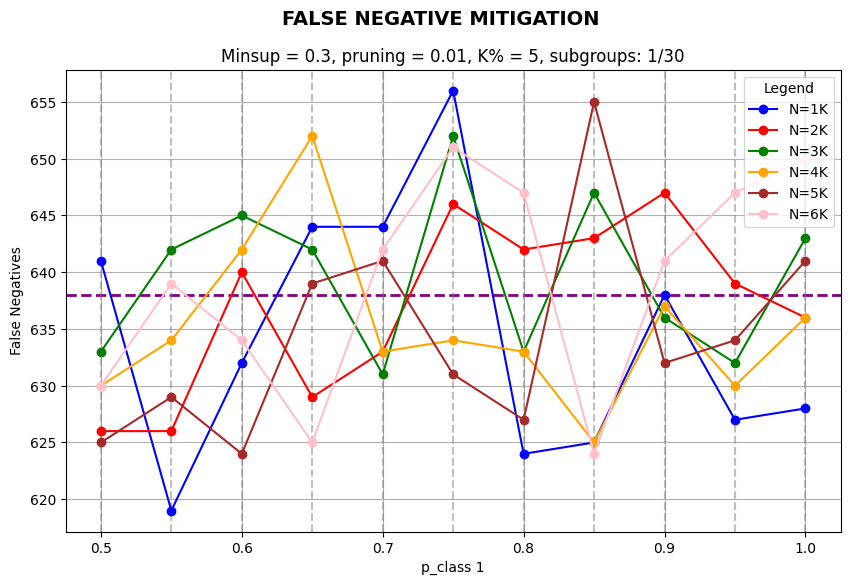

In [2035]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Nome del file JSON
json_filename = "false_negatives_K.json"

# Caricare i dati dal file JSON
with open(json_filename, "r") as f:
    false_negatives_data = json.load(f)

# Estrarre parametri dal JSON
run6_params = false_negatives_data.get("run6_parameters", {})
min_sup = run6_params.get("min_sup", "N/A")
percentage = run6_params.get("percentage", "N/A")
th_redundancy = run6_params.get("th_redundancy", "N/A")
L = run6_params.get("L", "N/A")
K = int((float(percentage) / 100) * int(L)) # K rappresenta il numero di sottogruppi

# Lista dei valori di p da 0.5 a 1.0 con step 0.05
p_values = np.arange(0.5, 1.05, 0.05)

# Definiamo i colori per ogni N
colors = ["blue", "red", "green", "orange", "brown", "pink"]
labels = [f"N={k}K" for k in range(1, 7)]

# Creazione della figura
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("FALSE NEGATIVE MITIGATION", fontsize=14, fontweight="bold")

# Disegniamo la linea tratteggiata "Before Mitigation"
before_mitigation = false_negatives_data.get("N=1K_run6", {}).get("Before Mitigation", None)
if before_mitigation is not None:
    ax.axhline(y=before_mitigation, color="purple", linestyle="--", linewidth=2, label="Before Mitigation")

# Aggiungere linee verticali per ogni valore di p
for p in p_values:
    ax.axvline(x=p, color="gray", linestyle="--", alpha=0.5)

# Loop sui vari N (da 1K a 6K)
legend_handles = []
for i, n in enumerate(range(1, 7)):
    N_key = f"N={n}K_run6"
    if N_key not in false_negatives_data:
        continue
    
    data = false_negatives_data[N_key]
    
    # Estrarre i valori di falsi positivi per ogni p
    false_positives = [data.get(f"After SMOTE N = {n*1000} p_class 1 = {round(p, 2)}", None) for p in p_values]
    
    # Filtriamo solo i valori validi
    p_values_filtered = [p for j, p in enumerate(p_values) if false_positives[j] is not None]
    false_positives_filtered = [fp for fp in false_positives if fp is not None]
    
    # Plottiamo la linea corrispondente
    line, = ax.plot(
        p_values_filtered, false_positives_filtered, 
        marker="o", linestyle="-", color=colors[i], label=labels[i]
    )
    legend_handles.append(line)

# Impostazioni asse
ax.set_title(f"Minsup = {min_sup}, pruning = {th_redundancy}, K% = {percentage}, subgroups: {K}/{L}")
ax.set_xlabel("p_class 1")
ax.set_ylabel("False Negatives")
ax.grid()

# Aggiungere la leggenda
ax.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True, title="Legend")

# Mostra il grafico
plt.show()